In [1]:
%load_ext autoreload
%autoreload 2
from src.chem_draw import draw_pwy_svg
from src.utils import ensure_dirs
import pickle
import subprocess
import pandas as pd

In [2]:
def thresholded_uniprot_strings(path_enzymes, enzyme_validation_threshold):
    uniprot_strings = []
    for rxn_enzymes in path_enzymes:
        if rxn_enzymes:
            up_str = ", ".join([e.uniprot_id for e in rxn_enzymes if e.validation_score >= enzyme_validation_threshold])
            uniprot_strings.append(up_str)
        else:
            uniprot_strings.append(None)

    return uniprot_strings

In [3]:
# Params
starters = 'ccm_v0'
targets = 'hopa'
generations = 3

expansion_dir = '../data/processed_expansions/'
fn = f"{starters}_to_{targets}_gen_{generations}_tan_sample_1_n_samples_1000.pkl" # Expansion file name

# Load processed expansions
with open(expansion_dir + fn, 'rb') as f:
    pe = pickle.load(f)


In [4]:
print(pe.starter_target_pairs)

{('oxaloacetate', 'hopa'), ('citrate', 'hopa'), ('succinate', 'hopa'), ('malate', 'hopa'), ('pyruvate', 'hopa')}


In [5]:
to_vis = {}
for st_pair in pe.starter_target_pairs:
    starter, target = st_pair
    enzyme_validation_threshold = 0.95
    sort_by = ['enzyme_validation', 'prc_mcs']
    filter_by = {'mdf':0, 'enzyme_validation':enzyme_validation_threshold}

    paths = pe.get_paths_w_st(starter=starter,
                    target=target,
                    sort_by=sort_by,
                    filter_by=filter_by,
                    reduce_predicted_reactions='min'
                    )
    
    if len(paths) > 0:
        print(f"{len(paths)} for {st_pair}")
        to_vis[st_pair] = paths

20 for ('oxaloacetate', 'hopa')
2 for ('succinate', 'hopa')
4 for ('malate', 'hopa')
11 for ('pyruvate', 'hopa')


In [6]:
sheets = []
sheetnames = []

for st_pair, paths in to_vis.items():
    print(st_pair)
    # Set up sheets headers & pwy svg outdir
    print("Generating svgs & csv")
    headers = ['id', 'starter', 'target', 'mdf', 'pwy_ave_mcs'] + [f"mcs_rxn_{g+1}" for g in range(generations)] + [f"uniprot_rxn_{g+1}" for g in range(generations)]
    pwy_svg_outdir = f"../artifacts/pwy_svgs/{fn[:-4]}/{'_'.join(st_pair)}/"
    ensure_dirs(pwy_svg_outdir)

    rows_for_sheet = []
    for path in paths:
        row = [] # One path
        up_strings = thresholded_uniprot_strings(pe.get_path_enzymes(path), enzyme_validation_threshold)
        prc_mcs = pe.get_path_prc_mcs(path) # Top-analogue prc_mcs for each predicted reaction in path 
        row += [path.id, path.starter, path.target, path.mdf, sum(prc_mcs) / len(prc_mcs)] # Append average prc_mcs

        # Append reaction prc_mcs
        for g in range(generations):
            if g < len(path.reaction_ids):
                row.append(prc_mcs[g])
            else:
                row.append(None)

        # Append uniprot strings
        for g in range(generations):
            if g < len(path.reaction_ids):
                row.append(up_strings[g])
            else:
                row.append(None)

        # Draw pathway svg 
        sma_hash_pairs = []
        for prid in path.reaction_ids:
            pr = pe.predicted_reactions[prid]
            analogue = pr.top_analogue()['analogue']
            sma_hash_pairs.append([(pr.smarts, prid), (analogue.smarts, analogue.id)])
        
        outpath = pwy_svg_outdir + f"{path.id:04}.svg"
        draw_pwy_svg(sma_hash_pairs, path.id, outpath)

        rows_for_sheet.append(row)

    # Make df for this st pair
    sheets.append(pd.DataFrame(rows_for_sheet, columns=headers).set_index('id'))
    sheetnames.append("_".join(st_pair))

    # Convert svgs to pdfs
    print("Generating pdfs")
    tmp_pdf_outdir = f"../artifacts/tmp_pdfs/{fn[:-4]}/{'_'.join(st_pair)}/"
    ensure_dirs(tmp_pdf_outdir)
    for path in paths:
        cmd = ["inkscape", f"--export-pdf={tmp_pdf_outdir}{path.id:04}.pdf", f"{pwy_svg_outdir}{path.id:04}.svg"]
        subprocess.run(cmd)

    # Concatenate pdfs
    print("Concatenating pdfs")
    pwy_pdf_outdir = f"../artifacts/pwy_pdfs/{fn[:-4]}/"
    ensure_dirs(pwy_pdf_outdir)
    cat_pdf_fn = pwy_pdf_outdir + '_'.join(st_pair) + '.pdf'
    individual_pwys = [f"{tmp_pdf_outdir}{path.id:04}.pdf" for path in paths]

    cmd = ["pdfunite", *individual_pwys, cat_pdf_fn]
    subprocess.run(cmd)

# Concatenate sheets into xls
print("Saving xlsx")
writer = pd.ExcelWriter(f"../artifacts/pwy_xls/{fn[:-4]}" + '.xlsx') # Arbitrary output name
for i, df in enumerate(sheets):
    df.to_excel(writer, sheet_name=sheetnames[i])
writer.save()

# Remove stuff
dirs = ['../artifacts/' + elt for elt in ['tmp_pdfs', 'rxn_svgs', 'pwy_svgs', 'mol_svgs']]
for elt in dirs:
    subprocess.run([f"rm -r {elt}/*"], shell=True)

('oxaloacetate', 'hopa')
Generating svgs & csv
Generating pdfs


Failed to get connection
** (org.inkscape.Inkscape:268797): CRITICAL **: 16:59:20.353: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:268797): CRITICAL **: 16:59:20.353: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:268797): CRITICAL **: 16:59:20.354: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:268827): CRITICAL **: 16:59:20.771: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:268827): CRITICAL **: 16:59:20.771: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:268827): CRITICAL **: 16:59:20.771: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:268850): CRITICAL **: 16:59:21.021: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.

Concatenating pdfs
('succinate', 'hopa')
Generating svgs & csv
Generating pdfs


Failed to get connection
** (org.inkscape.Inkscape:269283): CRITICAL **: 16:59:26.463: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:269283): CRITICAL **: 16:59:26.463: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:269283): CRITICAL **: 16:59:26.463: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:269307): CRITICAL **: 16:59:26.771: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:269307): CRITICAL **: 16:59:26.771: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:269307): CRITICAL **: 16:59:26.771: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


Concatenating pdfs
('malate', 'hopa')
Generating svgs & csv
Generating pdfs


Failed to get connection
** (org.inkscape.Inkscape:269338): CRITICAL **: 16:59:27.272: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:269338): CRITICAL **: 16:59:27.272: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:269338): CRITICAL **: 16:59:27.272: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:269361): CRITICAL **: 16:59:27.543: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:269361): CRITICAL **: 16:59:27.543: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:269361): CRITICAL **: 16:59:27.543: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:269384): CRITICAL **: 16:59:27.829: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.

Concatenating pdfs
('pyruvate', 'hopa')
Generating svgs & csv
Generating pdfs


Failed to get connection
** (org.inkscape.Inkscape:269433): CRITICAL **: 16:59:28.847: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:269433): CRITICAL **: 16:59:28.847: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:269433): CRITICAL **: 16:59:28.847: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:269462): CRITICAL **: 16:59:29.040: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:269462): CRITICAL **: 16:59:29.040: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:269462): CRITICAL **: 16:59:29.040: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:269485): CRITICAL **: 16:59:29.358: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.

Concatenating pdfs
Saving xlsx


In [44]:
path = pe.get_paths_w_id(565)[0]
rid = path.reaction_ids[0]
pr = pe.predicted_reactions[rid]
kr = pr.analogues[1]
smarts = kr.smarts

In [47]:
path.starter, path.target, pr.smarts, pr.id

('pyruvate',
 'mvacid',
 'CC(=O)C(=O)O.N[C@@H](CCC(=O)O)C(=O)O>>CC(N)C(=O)O.O=C(O)CCC(=O)C(=O)O',
 'R64c06f272a3c7cebb8af1ad13c7d361cc5a57de1cd4bbd607eecbdc1dfcb150a')

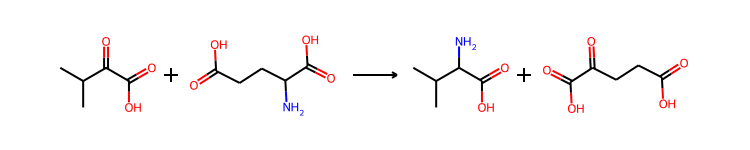

In [46]:
from rdkit import Chem
from rdkit.Chem import AllChem
from src.utils import load_json

AllChem.ReactionFromSmarts(smarts, useSmiles=True)

In [33]:
kr.database_entries, kr.id

([DatabaseEntry(db='brenda', id='5.4.99.4_1'),
  DatabaseEntry(db='brenda', id='5.4.99.4_2'),
  DatabaseEntry(db='kegg', id='R03908'),
  DatabaseEntry(db='metacyc', id='2-METHYLENEGLUTARATE-MUTASE-RXN_reverse')],
 'R2b570d17f1e302364ae56b8063cde96f6bc2dd20aba40bb92eb72d853598408f')

In [34]:
known_rxns = load_json("../data/mapping/known_rxns_jni_w_enzyme_validation.json")
known_rxns[kr.id]

{'smarts': 'C=C(CCC(=O)O)C(=O)O>>C=C(C(=O)O)C(C)C(=O)O',
 'imt_rules': ['rule0028_46', 'rule0028_46', 'rule0028_46'],
 'enzymes': [['Q59268',
   'MQEKTKRIIKEDIEAVRAYSDCFDVEMPDLDENGEVIGLPAPYPREVAGTVRSGYRIYDLAKKAKERGWPIQNPILGRNTAEETYGESQEMYAYADKFDETLFHFVHAEATRHIDPLKGRELINQSRGKGGITPIGEREFIAMGGGSKHPVRINATGDTPHLSIINALIAGFDGTDIGPVIHVHFGGRGIHDYKTKVVNGYKAIQICAENNIFVQLDSHKHLNNIGGTDGMALAMCLLSEGLAVHAGLPWELSAIQMNVAGINIYADLAVMRAFRKACHSKSIIAVPETFQNPPGNLVAEAAHFSRMAVTAKLGGADFYRPKAAESVGIPTGDSMGQAIWGTEDVFGHVVNPDIQSPVIDAREAEIIDEALAVLEATLHLEGLTLEAMTDDFWKQWSDEALIDLIVAAGKAGVLDSQRAAGWDLKRHVVVNRDKDGITRYVKGYTPLGVDASRCAQSDEDVEVHVEKAPTRPEKIVLATVGADAHVNGINVIREAFQDAGYDVVYLRGMNLPESVAEVAAEVGADAVGVSNLLGLGMELFPRVSKRLEELGLRDKMVVCAGGRIAEKEEEHRQFEEKIQKEGSAFMGMDGFFGPGSSPEDCVKIIGDMINAKKA',
   1.0,
   '1: Evidence at protein level',
   'UniProtKB reviewed (Swiss-Prot)',
   'Eubacterium barkeri']],
 'db_entries': [['brenda', '5.4.99.4_1'],
  ['brenda', '5.4.99.4_2'],
  ['kegg', 'R03908'],
  ['metacyc', '2-METHYLENEGLUTARATE-

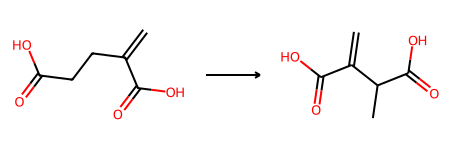

In [35]:

AllChem.ReactionFromSmarts('C=C(CCC(=O)O)C(=O)O>>C=C(C(=O)O)C(C)C(=O)O', useSmiles=True)

In [48]:
from minedatabase.pickaxe import Pickaxe
pk = Pickaxe()
pk.load_pickled_pickaxe("../data/raw_expansions/ccm_v0_to_mvacid_gen_4_tan_sample_1_n_samples_1000.pk")
pk.reactions[pr.id]

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading ../data/raw_expansions/ccm_v0_to_mvacid_gen_4_tan_sample_1_n_samples_1000.pk pickled data.
Loaded 58577 compounds
Loaded 77962 reactions
Loaded 3604 operators
Loaded 1 targets
Took 4.570807933807373


{'_id': 'R64c06f272a3c7cebb8af1ad13c7d361cc5a57de1cd4bbd607eecbdc1dfcb150a',
 'Reactants': [(1, 'X87786109ddfaf26b1b2b7f94e186203ed53d02e0'),
  (1, 'Cf7e036e330ad26caa66bb458faad18fa684af921')],
 'Products': [(1, 'C24f799b65f77e5bef0585b5d5138bb22868a8c16'),
  (1, 'Xe264bf1bbd482e436995855afdf2170ce7229f1d')],
 'Operators': {'rule0031_5'},
 'SMILES_rxn': '(1) CC(=O)C(=O)O + (1) N[C@@H](CCC(=O)O)C(=O)O => (1) CC(N)C(=O)O + (1) O=C(O)CCC(=O)C(=O)O'}